In [1]:
# 1. Load cleaned comments and captions CSVs
import pandas as pd

comments_df = pd.read_csv("/content/drive/MyDrive/CSE477/cleaned_comments.csv")
captions_df = pd.read_csv("/content/drive/MyDrive/CSE477/cleaned_captions.csv")

# 2. Ensure there is a 'cleaned_tokens' column
if 'cleaned_tokens' not in comments_df.columns:
    raise ValueError("Comments DataFrame missing 'cleaned_tokens' column")
if 'cleaned_tokens' not in captions_df.columns:
    raise ValueError("Captions DataFrame missing 'cleaned_tokens' column")

# 3. Join tokens back into strings for text analysis
# Assuming cleaned_tokens is stored as a list or string of tokens
comments_df["joined_text"] = comments_df["cleaned_tokens"].apply(
    lambda x: " ".join(eval(x)) if isinstance(x, str) else " ".join(x)
)
captions_df["joined_text"] = captions_df["cleaned_tokens"].apply(
    lambda x: " ".join(eval(x)) if isinstance(x, str) else " ".join(x)
)

print("Sample from comments:")
print(comments_df[["cleaned_tokens", "joined_text"]].head())

print("\nSample from captions:")
print(captions_df[["cleaned_tokens", "joined_text"]].head())

# 4. Install required packages if missing
try:
    import sklearn
    from matplotlib_venn import venn2
except ImportError:
    import sys
    !{sys.executable} -m pip install scikit-learn matplotlib-venn


Sample from comments:
                                      cleaned_tokens  \
0  ['thanks', 'amazingly', 'simplified', 'approac...   
1  ['yesterday', 'click', 'video', 'called', 'lea...   
2  ['ive', 'trying', 'learn', 'quite', 'awhile', ...   
3  ['fancy', 'word', 'simple', 'english', 'right'...   
4  ['anyone', 'getting', 'error', 'related', 'con...   

                                         joined_text  
0         thanks amazingly simplified approach reply  
1  yesterday click video called learning phyton b...  
2  ive trying learn quite awhile could never real...  
3  fancy word simple english right pace explain c...  
4  anyone getting error related converting list f...  

Sample from captions:
                                      cleaned_tokens  \
0  ['kylie', 'ying', 'worked', 'many', 'kylie', '...   
1                    ['let', 'actually', 'accuracy']   
2                    ['let', 'actually', 'accuracy']   
3  ['let', 'actually', 'make', 'five', 'make', 'f...   
4       

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ---------- 5. Vectorize comments ----------
vectorizer_comments = TfidfVectorizer(min_df=2, max_df=0.85)
tfidf_comments = vectorizer_comments.fit_transform(comments_df["joined_text"])

# ---------- 6. Extract top 15 keywords for comments ----------
feature_names_comments = vectorizer_comments.get_feature_names_out()
avg_tfidf_comments = tfidf_comments.mean(axis=0).A1  # average TF-IDF per term
keywords_comments = sorted(
    zip(feature_names_comments, avg_tfidf_comments),
    key=lambda x: x[1],
    reverse=True
)[:15]

# Save to CSV
comments_keywords_df = pd.DataFrame(keywords_comments, columns=["keyword", "score"])
comments_keywords_df.to_csv("/content/drive/MyDrive/CSE477/tfidf_keywords_comments.csv", index=False)


# ---------- 7. Vectorize captions ----------
vectorizer_captions = TfidfVectorizer(min_df=2, max_df=0.85)
tfidf_captions = vectorizer_captions.fit_transform(captions_df["joined_text"])

# Extract top 15 keywords
feature_names_captions = vectorizer_captions.get_feature_names_out()
avg_tfidf_captions = tfidf_captions.mean(axis=0).A1
keywords_captions = sorted(
    zip(feature_names_captions, avg_tfidf_captions),
    key=lambda x: x[1],
    reverse=True
)[:15]

# Save to CSV
captions_keywords_df = pd.DataFrame(keywords_captions, columns=["keyword", "score"])
captions_keywords_df.to_csv("/content/drive/MyDrive/CSE477/tfidf_keywords_captions.csv", index=False)


# ---------- 8–10. Print confirmation ----------
print("✅ Top 15 keywords saved:")
print("/content/drive/MyDrive/CSE477/tfidf_keywords_comments.csv")
print("/content/drive/MyDrive/CSE477/tfidf_keywords_captions.csv")


✅ Top 15 keywords saved:
/content/drive/MyDrive/CSE477/tfidf_keywords_comments.csv
/content/drive/MyDrive/CSE477/tfidf_keywords_captions.csv


Intersection (common keywords): set()

Unique to Comments: {'like', 'tutorial', 'woke', 'learning', 'youtube', 'thank', 'reply', 'understand', 'course', 'explanation', 'great', 'good', 'beginner', 'kylie', 'video', 'much', 'really', 'machine', 'thanks', 'best'}

Unique to Captions: {'okay', 'data', 'rid', 'itd', 'right', 'set', 'get', 'throw', 'going', 'actually', 'know', 'sorry', 'let', 'accuracy', 'row', 'one', 'equal', 'model', 'probability', 'say'}


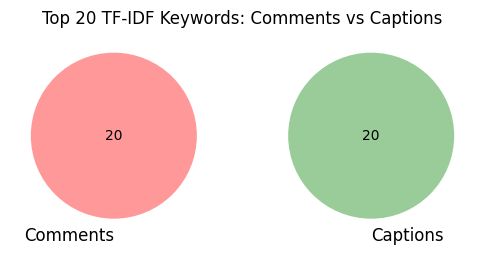

In [4]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# --- Get top 20 keywords for both ---
top20_comments = [w for w, _ in sorted(
    zip(feature_names_comments, avg_tfidf_comments),
    key=lambda x: x[1],
    reverse=True
)[:20]]

top20_captions = [w for w, _ in sorted(
    zip(feature_names_captions, avg_tfidf_captions),
    key=lambda x: x[1],
    reverse=True
)[:20]]

# --- 9. Intersection ---
intersection = set(top20_comments).intersection(set(top20_captions))

# --- 10. Unique keywords ---
unique_comments = set(top20_comments) - set(top20_captions)
unique_captions = set(top20_captions) - set(top20_comments)

print("Intersection (common keywords):", intersection)
print("\nUnique to Comments:", unique_comments)
print("\nUnique to Captions:", unique_captions)

# --- 11. Venn diagram ---
plt.figure(figsize=(6,6))
venn2([set(top20_comments), set(top20_captions)],
      set_labels=("Comments", "Captions"))
plt.title("Top 20 TF-IDF Keywords: Comments vs Captions")
plt.show()


12.Comments = audience reactions → gratitude, usefulness, learning experience, appreciation.

Captions = creator descriptions → technical, explanatory, and instructional focus.

The lack of overlap shows a clear role separation: captions guide the content, while comments reflect the audience’s perception and learning outcomes.

In [5]:
# --- 13. TF–IDF for bigrams ---
vectorizer_comments_bigram = TfidfVectorizer(ngram_range=(2,2), min_df=2, max_df=0.85)
tfidf_comments_bigram = vectorizer_comments_bigram.fit_transform(comments_df["joined_text"])

vectorizer_captions_bigram = TfidfVectorizer(ngram_range=(2,2), min_df=2, max_df=0.85)
tfidf_captions_bigram = vectorizer_captions_bigram.fit_transform(captions_df["joined_text"])

# --- 14. Top 10 bigrams for comments ---
feature_names_c_bigram = vectorizer_comments_bigram.get_feature_names_out()
avg_tfidf_c_bigram = tfidf_comments_bigram.mean(axis=0).A1
top10_comments_bigrams = sorted(
    zip(feature_names_c_bigram, avg_tfidf_c_bigram),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top 10 Comment Bigrams:")
print(top10_comments_bigrams)

# --- 15. Top 10 bigrams for captions ---
feature_names_cap_bigram = vectorizer_captions_bigram.get_feature_names_out()
avg_tfidf_cap_bigram = tfidf_captions_bigram.mean(axis=0).A1
top10_captions_bigrams = sorted(
    zip(feature_names_cap_bigram, avg_tfidf_cap_bigram),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("\nTop 10 Caption Bigrams:")
print(top10_captions_bigrams)

# --- 16. Compare overlap & uniqueness ---
top10_comments_set = set([w for w, _ in top10_comments_bigrams])
top10_captions_set = set([w for w, _ in top10_captions_bigrams])

intersection_bigrams = top10_comments_set.intersection(top10_captions_set)
unique_comments_bigrams = top10_comments_set - top10_captions_set
unique_captions_bigrams = top10_captions_set - top10_comments_set

print("\nIntersection (common bigrams):", intersection_bigrams)
print("Unique to Comments (bigrams):", unique_comments_bigrams)
print("Unique to Captions (bigrams):", unique_captions_bigrams)


Top 10 Comment Bigrams:
[('machine learning', np.float64(0.06509584326284767)), ('thank much', np.float64(0.037920326215027764)), ('kylie ying', np.float64(0.03074724608178854)), ('neural network', np.float64(0.019547292708478388)), ('data science', np.float64(0.018170972008793657)), ('youtube algorithm', np.float64(0.018098975786287278)), ('fell asleep', np.float64(0.0179330649782988)), ('woke reply', np.float64(0.01784381536073197)), ('thank kylie', np.float64(0.015230401075065021)), ('linear regression', np.float64(0.013382455666752086))]

Top 10 Caption Bigrams:
[('itd row', np.float64(0.06798266444275236)), ('let say', np.float64(0.059764479536830166)), ('actually let', np.float64(0.058466247536866946)), ('actually accuracy', np.float64(0.05536883579079925)), ('data set', np.float64(0.05534219447784333)), ('let get', np.float64(0.05527884096712011)), ('get rid', np.float64(0.051662357753083935)), ('batch size', np.float64(0.04895638190010223)), ('let actually', np.float64(0.045805

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


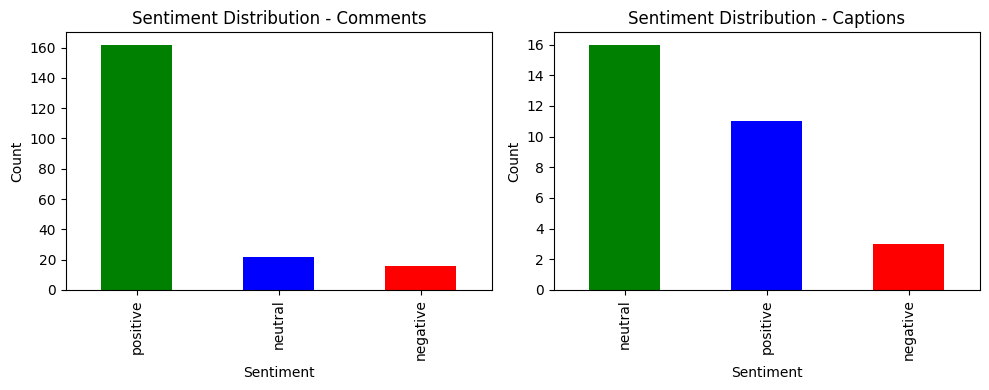

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# --- 17. Setup VADER ---
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# --- 18. Sentiment for Comments ---
comments_df["sentiment"] = comments_df["joined_text"].apply(get_sentiment_label)
sentiment_counts_comments = comments_df["sentiment"].value_counts()

# --- 19. Sentiment for Captions ---
captions_df["sentiment"] = captions_df["joined_text"].apply(get_sentiment_label)
sentiment_counts_captions = captions_df["sentiment"].value_counts()

# --- 20. Bar charts ---
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sentiment_counts_comments.plot(kind="bar", color=["green","blue","red"])
plt.title("Sentiment Distribution - Comments")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.subplot(1,2,2)
sentiment_counts_captions.plot(kind="bar", color=["green","blue","red"])
plt.title("Sentiment Distribution - Captions")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [9]:
from itertools import combinations
from collections import Counter

def cooccurring_pairs(df, top_terms, top_n=20):
    # Extract top keywords only
    tokens_list = df["joined_text"].str.split()
    pairs = []
    for tokens in tokens_list:
        tokens = [t for t in tokens if t in top_terms]
        for combo in combinations(set(tokens), 2):  # unique pairs
            pairs.append(tuple(sorted(combo)))
    return Counter(pairs).most_common(top_n)

# Example: Use top 20 terms from comments & captions
top_terms_comments = [w for w, _ in keywords_comments[:20]]
top_terms_captions = [w for w, _ in keywords_captions[:20]]

co_pairs_comments = cooccurring_pairs(comments_df, top_terms_comments)
co_pairs_captions = cooccurring_pairs(captions_df, top_terms_captions)

print("Top Co-occurring Pairs (Comments):", co_pairs_comments)
print("Top Co-occurring Pairs (Captions):", co_pairs_captions)


Top Co-occurring Pairs (Comments): [(('learning', 'machine'), 30), (('much', 'thank'), 15), (('learning', 'thank'), 13), (('learning', 'video'), 12), (('best', 'learning'), 12), (('course', 'learning'), 12), (('kylie', 'reply'), 11), (('course', 'thank'), 11), (('learning', 'reply'), 11), (('kylie', 'thank'), 11), (('reply', 'thank'), 10), (('like', 'video'), 10), (('course', 'kylie'), 9), (('reply', 'video'), 9), (('machine', 'reply'), 9), (('thank', 'video'), 9), (('learning', 'much'), 9), (('kylie', 'learning'), 9), (('course', 'reply'), 8), (('kylie', 'much'), 8)]
Top Co-occurring Pairs (Captions): [(('actually', 'let'), 15), (('let', 'say'), 12), (('okay', 'set'), 11), (('know', 'okay'), 11), (('going', 'okay'), 11), (('actually', 'know'), 11), (('know', 'say'), 11), (('know', 'set'), 11), (('going', 'set'), 11), (('going', 'know'), 11), (('know', 'let'), 11), (('actually', 'okay'), 10), (('okay', 'say'), 10), (('let', 'okay'), 10), (('okay', 'one'), 10), (('actually', 'say'), 10)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Simulate temporal split using row indices ---
midpoint_comments = len(comments_df) // 2
early_comments = comments_df.iloc[:midpoint_comments]
late_comments = comments_df.iloc[midpoint_comments:]

midpoint_captions = len(captions_df) // 2
early_captions = captions_df.iloc[:midpoint_captions]
late_captions = captions_df.iloc[midpoint_captions:]

# --- TF-IDF for early vs late comments ---
vec_comments = TfidfVectorizer(min_df=2, max_df=0.85)

tfidf_early_comments = vec_comments.fit_transform(early_comments["joined_text"])
tfidf_late_comments = vec_comments.fit_transform(late_comments["joined_text"])

early_terms_comments = sorted(
    zip(vec_comments.get_feature_names_out(), tfidf_early_comments.mean(axis=0).A1),
    key=lambda x: x[1],
    reverse=True
)[:15]

late_terms_comments = sorted(
    zip(vec_comments.get_feature_names_out(), tfidf_late_comments.mean(axis=0).A1),
    key=lambda x: x[1],
    reverse=True
)[:15]

print("Early Comments Top Terms:", early_terms_comments)
print("Late Comments Top Terms:", late_terms_comments)

# --- TF-IDF for early vs late captions ---
vec_captions = TfidfVectorizer(min_df=2, max_df=0.85)

tfidf_early_captions = vec_captions.fit_transform(early_captions["joined_text"])
tfidf_late_captions = vec_captions.fit_transform(late_captions["joined_text"])

early_terms_captions = sorted(
    zip(vec_captions.get_feature_names_out(), tfidf_early_captions.mean(axis=0).A1),
    key=lambda x: x[1],
    reverse=True
)[:15]

late_terms_captions = sorted(
    zip(vec_captions.get_feature_names_out(), tfidf_late_captions.mean(axis=0).A1),
    key=lambda x: x[1],
    reverse=True
)[:15]

print("Early Captions Top Terms:", early_terms_captions)
print("Late Captions Top Terms:", late_terms_captions)


Early Comments Top Terms: [('variation', np.float64(0.06306864427954945)), ('subject', np.float64(0.05411176333647907)), ('morning', np.float64(0.053268076078745875)), ('maximization', np.float64(0.04872329800732336)), ('vector', np.float64(0.04819852022233675)), ('distribution', np.float64(0.04458400731496058)), ('python', np.float64(0.04241485915760342)), ('oversampling', np.float64(0.040450200663130154)), ('key', np.float64(0.03837971842095672)), ('ying', np.float64(0.035323290585077396)), ('given', np.float64(0.030715456534813966)), ('easy', np.float64(0.026770527159632674)), ('negative', np.float64(0.02651288282967177)), ('step', np.float64(0.026275448017800743)), ('youre', np.float64(0.025915369096187902))]
Late Comments Top Terms: [('thanks', np.float64(0.09002636408624005)), ('reply', np.float64(0.07195054181950432)), ('video', np.float64(0.05079147308580431)), ('thank', np.float64(0.0460668436491069)), ('learning', np.float64(0.04337921988107417)), ('course', np.float64(0.0417

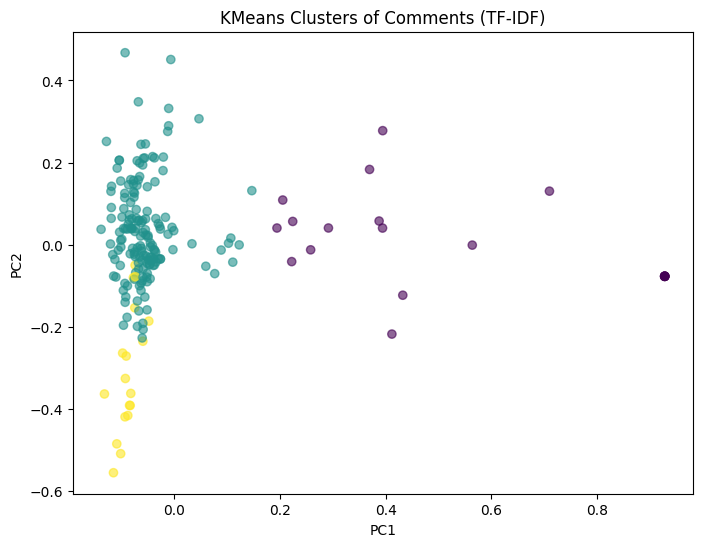

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use comments TF-IDF matrix
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_comments)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_comments.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=clusters, cmap="viridis", alpha=0.6)
plt.title("KMeans Clusters of Comments (TF-IDF)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
